In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import cv2
import os
import glob
import time

2025-08-28 09:46:34.112398: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
IMAGE_DIR = 'archive/images/val'
LABEL_DIR = 'archive/labels/val'

IMAGE_SIZE = (226, 226)  # Input image dimensions
GRID_SIZE = 7           # The image will be divided into a 7x7 grid (matches model output)

# confidence is the objectness score
OUTPUT_CHANNELS = 5

# --- Training Hyperparameters ---
BATCH_SIZE = 4
EPOCHS = 20
LEARNING_RATE = 0.001
VALIDATION_SPLIT = 0.2 # 20% of the data will be used for validation

# --- Inference Configuration ---
CONFIDENCE_THRESHOLD = 0.5  # Confidence threshold for displaying a bounding box
NMS_IOU_THRESHOLD = 0.4     # IoU threshold for Non-Max Suppression

In [ ]:
def parse_yolo_label(label_path, img_width, img_height):
    """
    Parses a YOLO format .txt file to get bounding box information.
    Args:
        label_path (str): Path to the label file.
        img_width (int): Original width of the corresponding image.
        img_height (int): Original height of the corresponding image.
    Returns:
        list: A list of bounding boxes, each as [x_center, y_center, width, height]
              in absolute pixel values. Returns an empty list if file not found.
    """
    boxes = []
    if not os.path.exists(label_path):
        return boxes
    with open(label_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            # YOLO format: class_id, x_center, y_center, width, height (all normalized)
            class_id = int(parts[0])
            x_center_norm = float(parts[1])
            y_center_norm = float(parts[2])
            width_norm = float(parts[3])
            height_norm = float(parts[4])

            # Convert normalized coordinates to absolute pixel values
            x_center = x_center_norm * img_width
            y_center = y_center_norm * img_height
            width = width_norm * img_width
            height = height_norm * img_height
            
            # We only have one class (person), so we ignore class_id for now
            boxes.append([x_center, y_center, width, height])
    return boxes


In [ ]:

import matplotlib.pyplot as plt

def plot_training_history(history):
    """
    Plots the training/validation loss and accuracy (IoU).
    """
    # Plot Loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.grid(True)

    # Plot Accuracy (IoU)
    plt.subplot(1, 2, 2)
    plt.plot(history.history['iou_metric'], label='Training IoU')
    plt.plot(history.history['val_iou_metric'], label='Validation IoU')
    plt.title('Model Accuracy (IoU)')
    plt.ylabel('IoU')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig('training_history.png')
    print("Training history plot saved as 'training_history.png'")
    plt.close()


In [ ]:

def create_target_tensor(boxes):
    """
    Converts a list of bounding boxes into the target tensor for the model.
    Args:
        boxes (list): A list of bounding boxes from parse_yolo_label.
    Returns:
        np.ndarray: The target tensor of shape (GRID_SIZE, GRID_SIZE, 5).
    """
    target = np.zeros((GRID_SIZE, GRID_SIZE, OUTPUT_CHANNELS), dtype=np.float32)
    cell_w = IMAGE_SIZE[1] / GRID_SIZE
    cell_h = IMAGE_SIZE[0] / GRID_SIZE

    for box in boxes:
        x_center, y_center, w, h = box

        # Determine which grid cell the center of the box falls into
        grid_x = int(x_center / cell_w)
        grid_y = int(y_center / cell_h)

        # Ensure grid indices are within bounds
        if grid_x < GRID_SIZE and grid_y < GRID_SIZE:
            # Set confidence score to 1 for this cell
            target[grid_y, grid_x, 4] = 1.0

            # Calculate box coordinates relative to the grid cell
            # These values will be between 0 and 1
            x_relative = (x_center % cell_w) / cell_w
            y_relative = (y_center % cell_h) / cell_h
            
            # Calculate box dimensions relative to the entire image
            # These values will be between 0 and 1
            w_relative = w / IMAGE_SIZE[1]
            h_relative = h / IMAGE_SIZE[0]

            target[grid_y, grid_x, 0] = x_relative
            target[grid_y, grid_x, 1] = y_relative
            target[grid_y, grid_x, 2] = w_relative
            target[grid_y, grid_x, 3] = h_relative
            
    return target


In [ ]:


def iou_metric(y_true, y_pred):
    """
    Custom Intersection over Union (IoU) metric.
    Only calculates IoU for grid cells that contain an object.
    """
    true_box, true_conf = y_true[..., :4], y_true[..., 4]
    pred_box, pred_conf = y_pred[..., :4], y_pred[..., 4]

    # Convert relative box coordinates to absolute coordinates (0 to 1 range)
    # This is a simplified IoU for the metric, not for loss calculation.
    true_x1 = true_box[..., 0] - true_box[..., 2] / 2
    true_y1 = true_box[..., 1] - true_box[..., 3] / 2
    true_x2 = true_box[..., 0] + true_box[..., 2] / 2
    true_y2 = true_box[..., 1] + true_box[..., 3] / 2

    pred_x1 = pred_box[..., 0] - pred_box[..., 2] / 2
    pred_y1 = pred_box[..., 1] - pred_box[..., 3] / 2
    pred_x2 = pred_box[..., 0] + pred_box[..., 2] / 2
    pred_y2 = pred_box[..., 1] + pred_box[..., 3] / 2

    # Calculate intersection area
    inter_x1 = tf.maximum(true_x1, pred_x1)
    inter_y1 = tf.maximum(true_y1, pred_y1)
    inter_x2 = tf.minimum(true_x2, pred_x2)
    inter_y2 = tf.minimum(true_y2, pred_y2)
    inter_area = tf.maximum(0.0, inter_x2 - inter_x1) * tf.maximum(0.0, inter_y2 - inter_y1)

    # Calculate union area
    true_area = true_box[..., 2] * true_box[..., 3]
    pred_area = pred_box[..., 2] * pred_box[..., 3]
    union_area = true_area + pred_area - inter_area
    
    # Calculate IoU and mask it to only include cells with objects
    iou = inter_area / (union_area + 1e-6) # Add epsilon to avoid division by zero
    
    # Only consider IoU for cells where an object is present
    responsibility_mask = true_conf
    masked_iou = iou * responsibility_mask
    
    # We want the mean IoU for the objects that are present in the batch
    return tf.reduce_sum(masked_iou) / (tf.reduce_sum(responsibility_mask) + 1e-6)


In [ ]:

import tf2onnx

def convert_to_onnx(model_path, output_path='person_detector.onnx'):
    """Converts the saved Keras model to ONNX format."""
    print(f"--- Converting model to ONNX format ---")
    try:
        model = keras.models.load_model(model_path, custom_objects={
            'custom_loss': custom_loss,
            'iou_metric': iou_metric
        })
        # The input signature is important for ONNX conversion
        spec = (tf.TensorSpec(model.input.shape, model.input.dtype, name="input"),)
        onnx_model, _ = tf2onnx.convert.from_keras(model, input_signature=spec)
        with open(output_path, "wb") as f:
            f.write(onnx_model.SerializeToString())
        print(f"Model successfully converted and saved as '{output_path}'")
    except Exception as e:
        print(f"An error occurred during ONNX conversion: {e}")


In [ ]:

def data_generator(image_paths, label_dir, batch_size):
    """
    A generator to load and preprocess data in batches.
    """
    num_samples = len(image_paths)
    while True:
        np.random.shuffle(image_paths)
        for offset in range(0, num_samples, batch_size):
            batch_paths = image_paths[offset:offset+batch_size]
            
            batch_images = []
            batch_labels = []

            for img_path in batch_paths:
                # Load and resize image
                img = cv2.imread(img_path)
                img_h, img_w, _ = img.shape
                img_resized = cv2.resize(img, (IMAGE_SIZE[1], IMAGE_SIZE[0]))
                img_normalized = img_resized / 255.0
                batch_images.append(img_normalized)

                # Get corresponding label path
                file_name = os.path.basename(img_path)
                label_name = os.path.splitext(file_name)[0] + '.txt'
                label_path = os.path.join(label_dir, label_name)

                # Parse labels and create target tensor
                # Note: The boxes are parsed relative to original dimensions,
                # but then scaled implicitly by resizing the image.
                # The target tensor calculation assumes coordinates are in the resized space.
                boxes_norm = parse_yolo_label(label_path, IMAGE_SIZE[1], IMAGE_SIZE[0])
                target = create_target_tensor(boxes_norm)
                batch_labels.append(target)

            yield np.array(batch_images), np.array(batch_labels)


In [ ]:

# ==============================================================================
# 3. MODEL ARCHITECTURE
# ==============================================================================

def create_detection_model(input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)):
    """
    Creates the CNN model for person detection, adapted from the user's notebook.
    The head is modified for object detection.
    """
    # Using the functional API for more flexibility
    inputs = keras.Input(shape=input_shape)

    # --- Feature Extractor (Convolutional Base from user's notebook) ---
    x = keras.layers.Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding='same')(inputs)
    x = keras.layers.Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.ReLU()(x)
    x = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid')(x)

    x = keras.layers.Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
    x = keras.layers.Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.ReLU()(x)
    x = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid')(x)

    x = keras.layers.Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
    x = keras.layers.Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.ReLU()(x)
    x = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid')(x)

    x = keras.layers.Conv2D(256, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
    x = keras.layers.Conv2D(256, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.ReLU()(x)
    x = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid')(x)
    
    # Add one more pooling layer to get from 26x26 to 13x13
    x = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid')(x)
    
    # --- Detection Head ---
    # The output of the base should be downsampled to GRID_SIZE x GRID_SIZE
    # The final conv layer produces the desired output channels
    # The output shape will be (GRID_SIZE, GRID_SIZE, 5)
    detection_output = keras.layers.Conv2D(OUTPUT_CHANNELS, (1, 1), activation='sigmoid', padding='same')(x)

    model = keras.Model(inputs=inputs, outputs=detection_output)
    return model


In [ ]:

# ==============================================================================
# 4. CUSTOM LOSS FUNCTION
# ==============================================================================

def custom_loss(y_true, y_pred):
    """
    Custom loss function for the object detection model.
    It combines localization loss (for bounding boxes) and confidence loss.
    """
    # Separate the true and predicted values
    true_box, true_conf = y_true[..., :4], y_true[..., 4]
    pred_box, pred_conf = y_pred[..., :4], y_pred[..., 4]

    # --- Confidence Loss ---
    # We want to penalize the model for incorrect confidence predictions.
    # This is treated as a binary classification problem for each grid cell.
    conf_loss = tf.keras.losses.binary_crossentropy(tf.expand_dims(true_conf, -1), tf.expand_dims(pred_conf, -1))
    
    # --- Localization Loss (Bounding Box Loss) ---
    # We only calculate box loss for cells that actually contain an object.
    # The 'responsibility mask' (true_conf) helps us do this.
    responsibility_mask = tf.expand_dims(true_conf, -1)
    box_loss = tf.reduce_sum(tf.square(true_box - pred_box) * responsibility_mask, axis=-1)

    # --- Total Loss ---
    # We can weight the losses. Here, we give more importance to box accuracy.
    lambda_box = 5.0
    lambda_noobj = 0.5 # Less penalty for confidence in cells with no object
    
    loss = (lambda_box * box_loss) + (conf_loss * (1.0 - true_conf)) * lambda_noobj + (conf_loss * true_conf)
    
    return tf.reduce_mean(loss)


In [ ]:

# ==============================================================================
# 5. INFERENCE AND VISUALIZATION
# ==============================================================================

def decode_predictions(predictions, confidence_threshold, nms_iou_threshold):
    """
    Decodes the model's raw output tensor into a list of final bounding boxes.
    Applies confidence thresholding and Non-Max Suppression.
    """
    boxes = []
    confidences = []

    cell_w = IMAGE_SIZE[1] / GRID_SIZE
    cell_h = IMAGE_SIZE[0] / GRID_SIZE

    # Iterate over each grid cell
    for y in range(GRID_SIZE):
        for x in range(GRID_SIZE):
            cell_preds = predictions[y, x, :]
            confidence = cell_preds[4]

            if confidence >= confidence_threshold:
                # Decode box coordinates
                x_rel, y_rel, w_rel, h_rel = cell_preds[:4]

                # Convert relative coordinates to absolute image coordinates
                abs_x_center = (x * cell_w) + (x_rel * cell_w)
                abs_y_center = (y * cell_h) + (y_rel * cell_h)
                abs_w = w_rel * IMAGE_SIZE[1]
                abs_h = h_rel * IMAGE_SIZE[0]

                # Convert center coordinates to top-left coordinates for NMS
                x1 = abs_x_center - (abs_w / 2)
                y1 = abs_y_center - (abs_h / 2)
                x2 = x1 + abs_w
                y2 = y1 + abs_h

                boxes.append([y1, x1, y2, x2]) # NMS expects [y1, x1, y2, x2]
                confidences.append(float(confidence))

    if not boxes:
        return [], []

    # Apply Non-Max Suppression
    indices = tf.image.non_max_suppression(
        boxes, confidences, max_output_size=50, iou_threshold=nms_iou_threshold
    )
    
    final_boxes = [boxes[i] for i in indices]
    final_confidences = [confidences[i] for i in indices]

    return final_boxes, final_confidences

def draw_boxes(image, boxes, confidences):
    """Draws bounding boxes on an image."""
    for box, conf in zip(boxes, confidences):
        y1, x1, y2, x2 = [int(coord) for coord in box]
        # Draw the rectangle
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
        # Prepare the label text
        label = f"Person: {conf:.2f}"
        # Get text size to draw a background rectangle
        (w, h), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 2)
        # Draw background and text
        cv2.rectangle(image, (x1, y1 - h - 10), (x1 + w, y1), (0, 255, 0), -1)
        cv2.putText(image, label, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0), 2)
    return image
    


In [ ]:
# ==============================================================================
# 6. MAIN SCRIPT LOGIC (TRAINING AND INFERENCE)
# ==============================================================================

def run_training():
    """Main function to run the training process."""
    print("--- Starting Training Process ---")
    
    # Find all image paths
    image_paths = glob.glob(os.path.join(IMAGE_DIR, '*.jpg')) + \
                  glob.glob(os.path.join(IMAGE_DIR, '*.png'))
    
    if not image_paths:
        print(f"Error: No images found in '{IMAGE_DIR}'. Please check the path.")
        return

    print(f"Found {len(image_paths)} images.")
    
    # Shuffle and split data
    np.random.shuffle(image_paths)
    split_index = int(len(image_paths) * (1 - VALIDATION_SPLIT))
    train_paths = image_paths[:split_index]
    val_paths = image_paths[split_index:]

    print(f"Training on {len(train_paths)} images, validating on {len(val_paths)} images.")

    # Create data generators
    train_gen = data_generator(train_paths, LABEL_DIR, BATCH_SIZE)
    val_gen = data_generator(val_paths, LABEL_DIR, BATCH_SIZE)

    # Create and compile the model
    model = create_detection_model()
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE), loss=custom_loss)
    model.summary()
    
    # Train the model
    print("\n--- Starting model training ---")
    global history
    history = model.fit(
        train_gen,
        steps_per_epoch=len(train_paths) // BATCH_SIZE,
        validation_data=val_gen,
        validation_steps=len(val_paths) // BATCH_SIZE,
        epochs=EPOCHS
    )
    
    # Save the trained model
    model.save('person_detector_model.h5')
    print("\n--- Training complete. Model saved as 'person_detector_model.h5' ---")


In [ ]:

def run_inference_on_image(model_path, image_path, output_path='output_image.jpg'):
    """Runs inference on a single image."""
    print(f"--- Running inference on image: {image_path} ---")
    model = keras.models.load_model(model_path, custom_objects={'custom_loss': custom_loss})
    
    image = cv2.imread(image_path)
    if image is None:
        print("Error: Could not read image.")
        return
        
    original_h, original_w, _ = image.shape
    
    # Preprocess image
    image_resized = cv2.resize(image, (IMAGE_SIZE[1], IMAGE_SIZE[0]))
    image_input = image_resized / 255.0
    image_input = np.expand_dims(image_input, axis=0) # Add batch dimension
    
    # Get predictions
    predictions = model.predict(image_input)[0] # Remove batch dimension
    
    # Decode predictions and draw boxes
    boxes, confidences = decode_predictions(predictions, CONFIDENCE_THRESHOLD, NMS_IOU_THRESHOLD)
    
    # Scale boxes back to original image size
    final_boxes_scaled = []
    for box in boxes:
        y1, x1, y2, x2 = box
        y1_s = y1 * (original_h / IMAGE_SIZE[0])
        x1_s = x1 * (original_w / IMAGE_SIZE[1])
        y2_s = y2 * (original_h / IMAGE_SIZE[0])
        x2_s = x2 * (original_w / IMAGE_SIZE[1])
        final_boxes_scaled.append([y1_s, x1_s, y2_s, x2_s])

    output_image = draw_boxes(image.copy(), final_boxes_scaled, confidences)
    
    # Save and display the output
    cv2.imwrite(output_path, output_image)
    print(f"Found {len(final_boxes_scaled)} person(s). Output saved to '{output_path}'")
    # To display the image in a window (if you have a GUI environment)
    # cv2.imshow('Detections', output_image)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()


In [ ]:

def run_inference_on_video(model_path, video_path, output_path='output_video.mp4'):
    """Runs inference on a video file and displays it live."""
    print(f"--- Running inference on video: {video_path} ---")
    model = keras.models.load_model(model_path, custom_objects={'custom_loss': custom_loss})
    
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error: Could not open video file.")
        return

    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        frame_resized = cv2.resize(frame, (IMAGE_SIZE[1], IMAGE_SIZE[0]))
        frame_input = frame_resized / 255.0
        frame_input = np.expand_dims(frame_input, axis=0)
        
        predictions = model.predict(frame_input)[0]
        
        boxes, confidences = decode_predictions(predictions, CONFIDENCE_THRESHOLD, NMS_IOU_THRESHOLD)
        
        final_boxes_scaled = []
        for box in boxes:
            y1, x1, y2, x2 = box
            y1_s = y1 * (height / IMAGE_SIZE[0])
            x1_s = x1 * (width / IMAGE_SIZE[1])
            y2_s = y2 * (height / IMAGE_SIZE[0])
            x2_s = x2 * (width / IMAGE_SIZE[1])
            final_boxes_scaled.append([y1_s, x1_s, y2_s, x2_s])
            
        output_frame = draw_boxes(frame.copy(), final_boxes_scaled, confidences)
        
        out.write(output_frame)
        
        # Display the resulting frame
        cv2.imshow('Live Inference - Press Q to Quit', output_frame)
        
        # Press 'q' on keyboard to exit
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    print(f"--- Video processing complete. Output video saved to '{output_path}' ---")
    
    cap.release()
    out.release()
    cv2.destroyAllWindows()

In [4]:
run_training()

--- Starting Training Process ---
Found 4000 images.
Training on 3200 images, validating on 800 images.


I0000 00:00:1756353376.008448    8711 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2606 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 226, 226, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 226, 226, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 226, 226, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 226, 226, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 226, 226, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 113, 113, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 113, 113, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 113, 113, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 113, 113, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 113, 113, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 7, 7, 5)        │         1,28

 Total params: 1,175,461 (4.48 MB)

 Trainable params: 1,174,501 (4.48 MB)

 Non-trainable params: 960 (3.75 KB)


--- Starting model training ---
Epoch 1/20


2025-08-28 09:26:19.519324: I external/local_xla/xla/service/service.cc:163] XLA service 0x725130014e20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-08-28 09:26:19.519360: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2025-08-28 09:26:19.626082: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-08-28 09:26:20.195832: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91200
2025-08-28 09:26:20.511703: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[4,32,226,226]{3,2,1,0}, u8[0]{0}) custom-call(f32[4,3,226,226]{3,2,1,0}, f32[32,3,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_t

  3/800 ━━━━━━━━━━━━━━━━━━━━ 44s 56ms/step - loss: 0.7377   

I0000 00:00:1756353388.303727    8774 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


800/800 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - loss: 0.2616 - val_loss: 0.2864
Epoch 2/20
800/800 ━━━━━━━━━━━━━━━━━━━━ 35s 44ms/step - loss: 0.2477 - val_loss: 0.2318
Epoch 3/20
800/800 ━━━━━━━━━━━━━━━━━━━━ 35s 44ms/step - loss: 0.2419 - val_loss: 0.3229
Epoch 4/20
800/800 ━━━━━━━━━━━━━━━━━━━━ 35s 44ms/step - loss: 0.2392 - val_loss: 0.2300
Epoch 5/20
800/800 ━━━━━━━━━━━━━━━━━━━━ 35s 44ms/step - loss: 0.2353 - val_loss: 0.2611
Epoch 6/20
800/800 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - loss: 0.2330 - val_loss: 0.2245
Epoch 7/20
800/800 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - loss: 0.2294 - val_loss: 0.2229
Epoch 8/20
800/800 ━━━━━━━━━━━━━━━━━━━━ 35s 44ms/step - loss: 0.2267 - val_loss: 0.2215
Epoch 9/20
800/800 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - loss: 0.2236 - val_loss: 0.2160
Epoch 10/20
800/800 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - loss: 0.2206 - val_loss: 0.2127
Epoch 11/20
800/800 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - loss: 0.2190 - val_loss: 0.2098
Epoch 12/20
800/800 ━━━━━━━━━━━━━━━━━━━━ 


--- Training complete. Model saved as 'person_detector_model.h5' ---


KeyError: 'iou_metric'

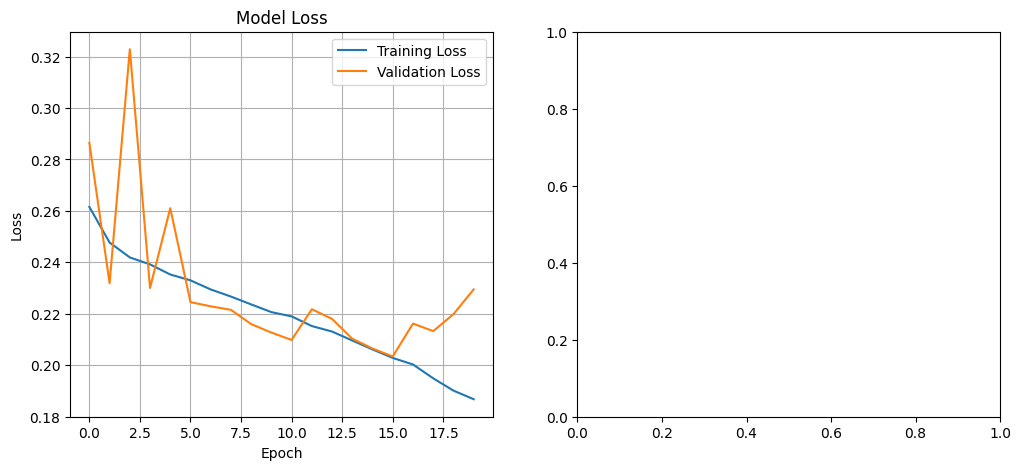

In [12]:
plot_training_history(history)

In [ ]:
MODEL_FILE = 'person_detector_model.h5'
IMAGE_FILE = 'e0e3506f627b4374bd15dc7aeeceb2f7.jpg'

if not os.path.exists(MODEL_FILE):
    print(f"Error: Model file '{MODEL_FILE}' not found. Please train the model first.")
elif not os.path.exists(IMAGE_FILE):
    print(f"Error: Image file '{IMAGE_FILE}' not found.")
else:
    run_inference_on_image(MODEL_FILE, IMAGE_FILE)

In [ ]:
MODEL_FILE = 'object_detector_model_tf/person_detector_model.h5'
VIDEO_FILE = 'archive/ssvid.net--HUGE-Speech-Practice-Audience-with-Applause-5-minute-presentation_1080p.mp4'

if not os.path.exists(MODEL_FILE):
    print(f"Error: Model file '{MODEL_FILE}' not found. Please train the model first.")
elif not os.path.exists(VIDEO_FILE):
    print(f"Error: Video file '{VIDEO_FILE}' not found.")
else:
    run_inference_on_video(MODEL_FILE, VIDEO_FILE)

In [5]:
convert_to_onnx("object_detector_model_tf/person_detector_model.h5", "object_detector_model_tf/person_detector_model.onnx")

--- Converting model to ONNX format ---


I0000 00:00:1756354618.678455   10624 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2606 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5
I0000 00:00:1756354619.692466   10624 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
I0000 00:00:1756354619.692593   10624 single_machine.cc:376] Starting new session
I0000 00:00:1756354619.697986   10624 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2606 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5
I0000 00:00:1756354619.879653   10624 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2606 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5
I0000 00:00:1756354619.906450   10624 devices.cc:67] Number of eligible GPUs (core count

Model successfully converted and saved as 'object_detector_model_tf/person_detector_model.onnx'


In [6]:
import onnxruntime as ort
import cv2

def run_inference_on_video_onnx(onnx_model_path, video_path, output_path='output_video_onnx.mp4'):
    print(f"--- Running ONNX inference on video: {video_path} ---")
    session = ort.InferenceSession(onnx_model_path)
    input_name = session.get_inputs()[0].name

    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error: Could not open video file.")
        return

    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        frame_resized = cv2.resize(frame, (IMAGE_SIZE[1], IMAGE_SIZE[0]))
        frame_input = frame_resized / 255.0
        frame_input = np.expand_dims(frame_input, axis=0).astype(np.float32)

        preds = session.run(None, {input_name: frame_input})[0][0]

        boxes, confidences = decode_predictions(preds, CONFIDENCE_THRESHOLD, NMS_IOU_THRESHOLD)

        final_boxes_scaled = []
        for box in boxes:
            y1, x1, y2, x2 = box
            y1_s = y1 * (height / IMAGE_SIZE[0])
            x1_s = x1 * (width / IMAGE_SIZE[1])
            y2_s = y2 * (height / IMAGE_SIZE[0])
            x2_s = x2 * (width / IMAGE_SIZE[1])
            final_boxes_scaled.append([y1_s, x1_s, y2_s, x2_s])

        output_frame = draw_boxes(frame.copy(), final_boxes_scaled, confidences)
        out.write(output_frame)

        cv2.imshow('ONNX Live Inference - Press Q to Quit', output_frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    print(f"--- Video processing complete. Output video saved to '{output_path}' ---")
    cap.release()
    out.release()
    cv2.destroyAllWindows()

# Example usage:
run_inference_on_video_onnx("object_detector_model_tf/person_detector_model.onnx", "archive/ssvid.net--HUGE-Speech-Practice-Audience-with-Applause-5-minute-presentation_1080p.mp4")

--- Running ONNX inference on video: archive/ssvid.net--HUGE-Speech-Practice-Audience-with-Applause-5-minute-presentation_1080p.mp4 ---
--- Video processing complete. Output video saved to 'output_video_onnx.mp4' ---
